# Analyzing Campaign Finance Records for 2024 Gubernatorial Race of Candidate Patrick Morrissey (R)

This project is necessary for multiple reasons, as mentioned in the [README document](https://github.com/austindizzy/wvcfrs-parser/blob/master/README.md), including the ability to do quick data analysis on political campaigns in West Virginia. Let's use the structured data returned by this tool to do some of that quick data analysis on the campaign finance data of Patrick Morrisey (R) for WV Governor.

Total number of contributions: 71634
Total amount of contributions: $4,280,320.15
Average contribution amount: $59.75
Median contribution amount: $4.95
Largest contribution: $6,600.00
Smallest contribution: $0.01


<Figure size 1200x800 with 0 Axes>

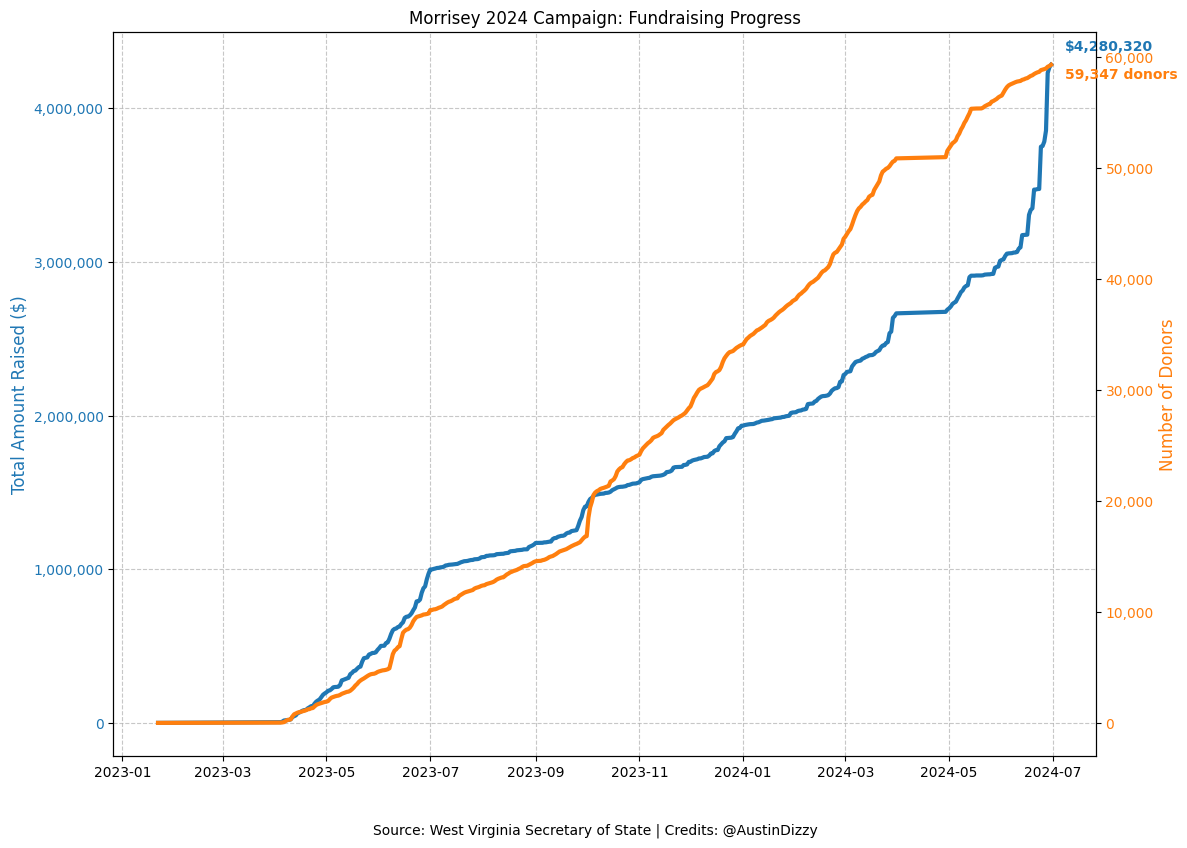

In [93]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd


conn = sqlite3.connect("./morrisey-2024.sqlite3")

df_over_250 = pd.read_sql_query("SELECT * FROM contributions_over_250", conn)
df_under_250 = pd.read_sql_query("SELECT * FROM contributions_under_250", conn)
df_all = pd.concat(
    [
        df_over_250[["date", "name", "election_type", "amount"]],
        df_under_250[["date", "name", "election_type", "amount"]],
    ]
)

df_over_250["date"] = pd.to_datetime(df_over_250["date"])
df_under_250["date"] = pd.to_datetime(df_under_250["date"])
df_all["date"] = pd.to_datetime(df_all["date"])
df_all["name"] = df_all["name"].apply(lambda x: x.upper().strip())

# if employer/occupation is "RETIRED RETIRED", replace with "RETIRED"
# same with "HOMEMAKER HOMEMAKER"
df_over_250["employer_occupation"] = df_over_250["employer_occupation"].str.replace(
    "RETIRED RETIRED", "RETIRED"
)

# Basic statistics
print(f"Total number of contributions: {len(df_all)}")
print(f"Total amount of contributions: ${df_all['amount'].sum():,.2f}")
print(f"Average contribution amount: ${df_all['amount'].mean():,.2f}")
print(f"Median contribution amount: ${df_all['amount'].median():,.2f}")
print(f"Largest contribution: ${df_all['amount'].max():,.2f}")
print(f"Smallest contribution: ${df_all['amount'].min():,.2f}")

# Create cumulative sums
df_cumulative = df_all.groupby('date').agg({
    'amount': 'sum',
    'name': lambda x: x.nunique()
}).cumsum().reset_index()

# Create the plot
plt.figure(figsize=(12, 8))
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot cumulative amount
ax1.plot(df_cumulative['date'], df_cumulative['amount'], color='#1f77b4', linewidth=3)
ax1.set_ylabel('Total Amount Raised ($)', color='#1f77b4', fontsize=12)
ax1.tick_params(axis='y', labelcolor='#1f77b4')

# Create a twin axis for number of donors
ax2 = ax1.twinx()
ax2.plot(df_cumulative['date'], df_cumulative['name'], color='#ff7f0e', linewidth=3)
ax2.set_ylabel('Number of Donors', color='#ff7f0e', fontsize=12)
ax2.tick_params(axis='y', labelcolor='#ff7f0e')

plt.title("Morrisey 2024 Campaign: Fundraising Progress")
plt.xlabel("Date")
ax1.grid(True, linestyle='--', alpha=0.7)

# Format y-axis labels to use commas as thousand separators
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# Add annotations for final values
last_date = df_cumulative['date'].iloc[-1]
last_amount = df_cumulative['amount'].iloc[-1]
last_donors = df_cumulative['name'].iloc[-1]

ax1.annotate(f'${last_amount:,.0f}',
             (last_date, last_amount),
             xytext=(10, 10), textcoords='offset points',
             color='#1f77b4', fontweight='bold')

ax2.annotate(f'{last_donors:,.0f} donors', 
             (last_date, last_donors),
             xytext=(10, -10), textcoords='offset points',
             color='#ff7f0e', fontweight='bold')


plt.figtext(0.5, -0.05, "Source: West Virginia Secretary of State | Credits: @AustinDizzy", 
            ha="center", fontsize=10)

plt.tight_layout()
plt.show()

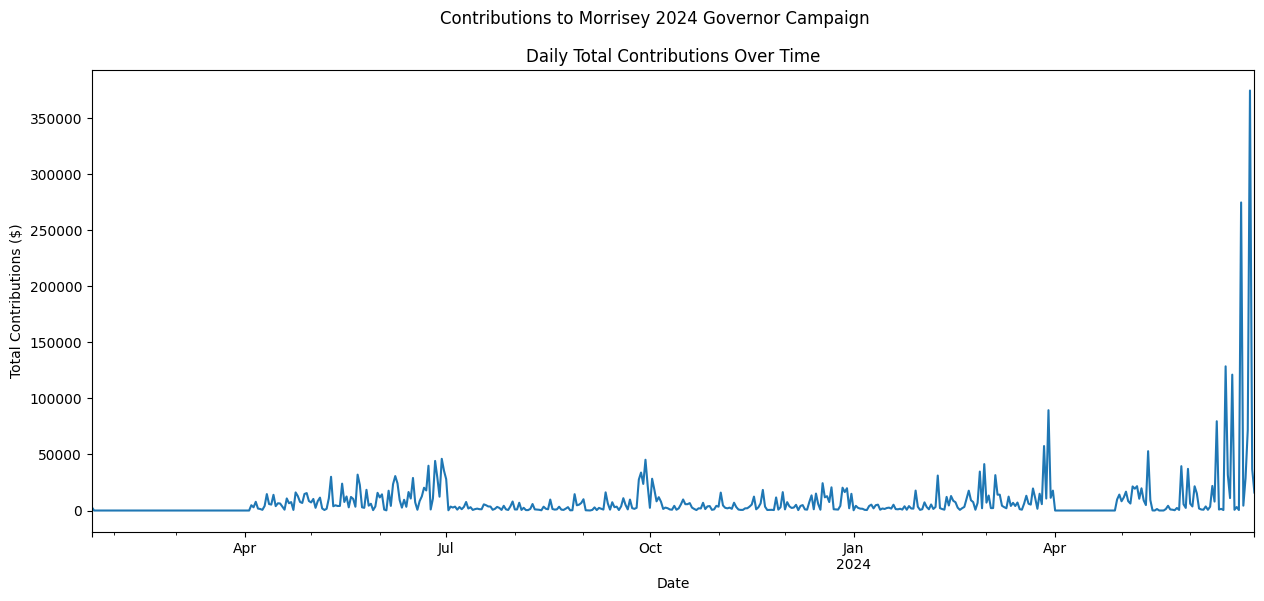

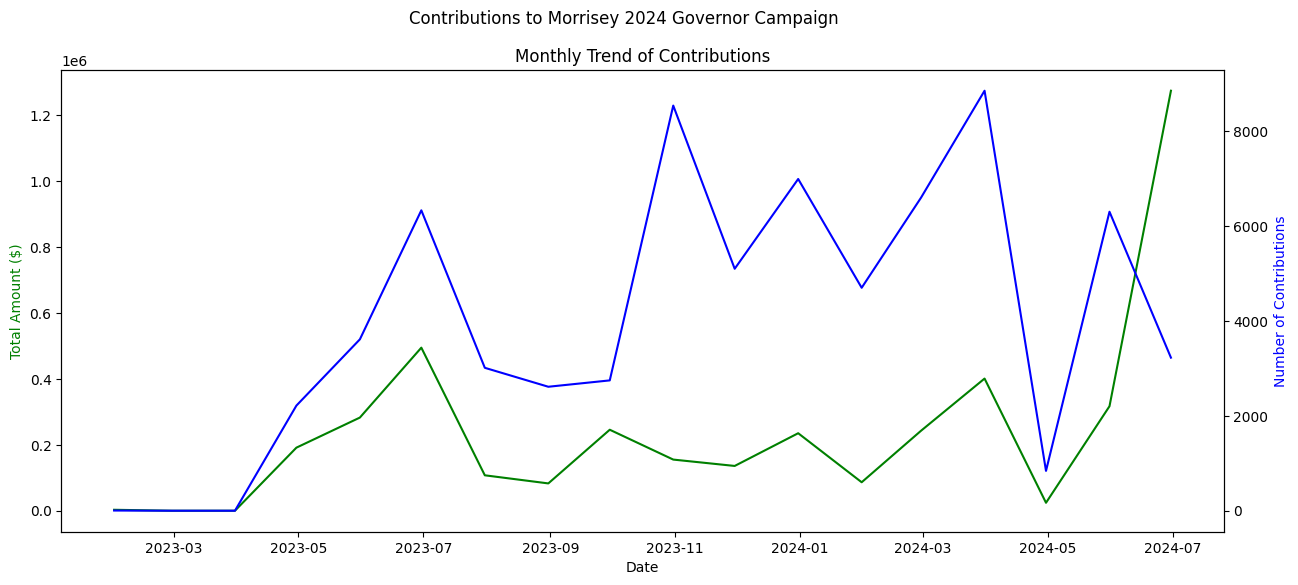

In [94]:
# Time frequency distribution of donations
plt.figure(figsize=(15, 6))
df_all.resample("D", on="date")["amount"].sum().plot()
plt.suptitle("Contributions to Morrisey 2024 Governor Campaign")
plt.title("Daily Total Contributions Over Time")
plt.xlabel("Date")
plt.ylabel("Total Contributions ($)")
plt.show()

# Monthly trend
monthly_trend = df_all.resample("M", on="date").agg({"amount": "sum", "date": "count"})
monthly_trend.columns = ["Total Amount", "Number of Contributions"]

fig, ax1 = plt.subplots(figsize=(15, 6))
ax2 = ax1.twinx()
ax1.plot(monthly_trend.index, monthly_trend["Total Amount"], "g-")
ax2.plot(monthly_trend.index, monthly_trend["Number of Contributions"], "b-")
ax1.set_xlabel("Date")
ax1.set_ylabel("Total Amount ($)", color="g")
ax2.set_ylabel("Number of Contributions", color="b")
plt.suptitle("Contributions to Morrisey 2024 Governor Campaign")
plt.title("Monthly Trend of Contributions")
plt.show()

In [95]:
import plotly.express as px
import pandas as pd
import numpy as np
import re

def extract_state(addr):
    addr_rgx = re.compile(r", ([A-Z]{2}) \d{5}$", flags=re.IGNORECASE)
    if addr_rgx.search(addr) is None:
        return np.nan
    return addr_rgx.search(addr).group(1).upper().strip()


def extract_zip(addr):
    zip_rgx = re.compile(r"(\d{5})$", flags=re.IGNORECASE)
    if zip_rgx.search(addr) is None:
        return np.nan
    return zip_rgx.search(addr).group(1).strip()


# Extract state and ZIP code from the address
df_over_250["state"] = df_over_250["address"].apply(extract_state)
df_over_250["zip_code"] = df_over_250["address"].apply(extract_zip)

# Aggregate data by state and ZIP code
state_data = df_over_250.groupby("state").agg({"amount": "sum", "name": "count"})
state_data.columns = ["total_amount", "num_contributions"]
state_data = state_data.reset_index()

print(state_data.sort_values("total_amount", ascending=False))

def create_layout(title, subtitle):
    return dict(
        title=dict(text=f"{title}<br><sup>{subtitle}</sup>", font=dict(size=24)),
        annotations=[
            dict(
                text="Source: West Virginia Secretary of State | Credits: @AustinDizzy",
                showarrow=False,
                xref="paper",
                yref="paper",
                x=0.5,
                y=-0.1,
                font=dict(size=12),
            )
        ],
        margin=dict(l=0, r=0, t=100, b=100),
        height=800,
        width=1200,
    )

fig_state_amt = px.choropleth(
    state_data,
    locations="state",
    locationmode="USA-states",
    color="total_amount",
    hover_name="state",
    hover_data=["num_contributions"],
    scope="usa",
    color_continuous_scale="pubu",
)

fig_state_num = px.choropleth(
    state_data,
    locations="state",
    locationmode="USA-states",
    color="num_contributions",
    hover_name="state",
    hover_data=["num_contributions"],
    scope="usa",
    color_continuous_scale="pubu",
)

fig_state_amt.update_layout(
    create_layout(
        "Total Contributions by State", "Morrisey 2024 Campaign for WV Governor"
    ),
    coloraxis_colorbar=dict(
        title="Total Amount ($)",
        len=0.75,
        thickness=20,
    ),
    geo=dict(
        showlakes=False,
        showrivers=False,
    ),
)

fig_state_num.update_layout(
    create_layout(
        "Number of Contributions by State", "Morrisey 2024 Campaign for WV Governor"
    ),
    coloraxis_colorbar=dict(
        title="Number of Contributions",
        len=0.75,
        thickness=20,
    ),
    geo=dict(
        showlakes=False,
        showrivers=False,
    ),
)

# Add state abbreviations
for state in state_data["state"]:
    fig_state_amt.add_annotation(
        x=state_data[state_data["state"] == state]["total_amount"].iloc[0],
        y=state,
        text=state,
        showarrow=False,
        font=dict(size=8, color="black"),
    )
    fig_state_num.add_annotation(
        x=state_data[state_data["state"] == state]["num_contributions"].iloc[0],
        y=state,
        text=state,
        showarrow=False,
        font=dict(size=8, color="black"),
    )

fig_state_amt.update_coloraxes(cmin=0, cmax=state_data["total_amount"].max())
fig_state_num.update_coloraxes(cmin=0, cmax=state_data["num_contributions"].max())

fig_state_amt.update_layout(
    create_layout(
        "Total Contributions by State", "Morrisey 2024 Campaign for WV Governor"
    ),
    coloraxis_colorbar=dict(title="Total Amount ($)"),
)
fig_state_num.update_layout(
    create_layout(
        "Number of Contributions by State", "Morrisey 2024 Campaign for WV Governor"
    ),
    coloraxis_colorbar=dict(title="Number of Contributions"),
)

fig_state_amt.show()
fig_state_num.show()

   state  total_amount  num_contributions
48    WV    1428593.95                934
9     FL     228666.81                700
43    TX     205185.77                557
4     CA     173930.84                405
45    VA     173806.44                228
16    KY     106970.43                 97
38    PA     106885.86                206
35    OH     103203.16                230
17    LA     101856.88                 62
10    GA      95953.98                270
26    NC      80384.86                 85
42    TN      69177.56                 95
34    NY      65387.43                137
7     DC      60667.28                 42
3     AZ      52511.66                 61
13    IL      45210.15                207
19    MD      40990.86                122
40    SC      40475.34                127
14    IN      34579.23                187
5     CO      31734.24                 80
24    MS      30310.40                 90
30    NJ      28488.31                104
23    MO      24172.10            

In [96]:
import requests
import io
import os
import zipfile

# Load the GeoNames dataset for ZIP code information
# Credits: https://www.geonames.org/about.html
geonames_url = "https://download.geonames.org/export/zip/US.zip"
if not os.path.exists("US.txt"):
    print("Downloading GeoNames ZIP code data...")
    z = zipfile.ZipFile(io.BytesIO(requests.get(geonames_url).content))
    z.extractall()

geonames = pd.read_csv(
    "./US.txt",
    sep="\t",
    header=None,
    names=[
        "country_code",
        "postal_code",
        "place_name",
        "admin_name1",
        "admin_code1",
        "admin_name2",
        "admin_code2",
        "admin_name3",
        "admin_code3",
        "latitude",
        "longitude",
        "accuracy",
    ],
)

zip_dict = dict(
    zip(geonames["postal_code"], zip(geonames["latitude"], geonames["longitude"]))
)

def get_lat_lon(zip_code):
    return zip_dict.get(int(zip_code.strip()), (np.nan, np.nan))

zip_data = df_over_250.groupby("zip_code").agg(
    {"amount": "sum", "name": "count", "state": "first"}
)
zip_data.columns = ["total_amount", "num_contributions", "state"]
zip_data = zip_data.reset_index()

# Add lat and lon to zip_data
zip_data["lat"], zip_data["lon"] = zip(*zip_data["zip_code"].apply(get_lat_lon))
# Remove rows with missing lat/lon
zip_data = zip_data.dropna(subset=["lat", "lon"])

# Create ZIP code heat map using scatter_geo
fig_zip_heat = px.scatter_geo(
    zip_data,
    lat="lat",
    lon="lon",
    color="total_amount",
    size="total_amount",
    hover_name="zip_code",
    hover_data=["state", "num_contributions"],
    scope="usa",
    color_continuous_scale="jet",
)

fig_zip_heat.update_layout(
    create_layout(
        "Contribution Heat Map by ZIP Code", "Morrisey 2024 Campaign for WV Governor"
    ),
    coloraxis_colorbar=dict(title="Total Amount ($)"),
)

fig_zip_heat.show()